# Optimización matemática

¿Qué significa [óptimo](https://dle.rae.es/%C3%B3ptimo)?

> Sumamente bueno, que no puede ser mejor

Pero el significado de "mejor" depende de la situación. Considere por ejemplo el problema de escoger la ruta que debe tomar un vehículo de reparto de carga 

La "mejor" ruta pudiera ser 

- la ruta más rápida
- la ruta más barata
- la ruta más directa

:::{important}

Para encontrar la mejor ruta primero debemos definir el **criterio** en que basaremos nuestra decisión

:::

En el ejemplo anterior tenemos

- la ruta de mínimo **tiempo**
- la ruta de mínimo **costo**
- la ruta de mínima **distancia**

La selección de la mejor ruta es un ejemplo de **optimización**. Más en general, la optimización es:

> El proceso de encontrar la mejor solución para un problema dentro de un conjunto de posibilidades

La optimización es un área bastante estudiada de las matemáticas y algunos problemas de optimización requieren de soluciones muy específicas

El objetivo de esta lección es entregar una revisión general a los problemas de optimización que podemos resolver usando las herramientas del módulo `scipy.optimize`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

## Modelamiento matemático de un problema

Para encontrar la mejor solución de un problema debemos primero modelarlo matemáticamente. En su forma más básica esto significa escribir el criterio de decisión como una función

> Llamamos a esta función, la **función objetivo** del problema

Para el problema del vehículo de reparto que comentamos en la introducción, si tenemos una variable $x$ que define la ruta y una función $f(x)$ que retorna el tiempo de dicha ruta, podemos escribir

$$
\min_x f(x)
$$

Supongamos ahora que el vehículo debe pasar por un cierto punto de la ciudad durante el reparto. La mejor ruta es ahora la de mínimo tiempo que además pasa por ese punto

> Llamamos **restricciones**, a las condiciones adicionales que debe cumplir la mejor solución

Incluyendo restricciones el modelo matemático de nuestro problema sería

$$
\begin{split}
\min_x &f(x)  \\
\text{sujeto a: } & g_i(x) = 0, i=1,2\ldots, I \\  
& h_j(x) \leq 0, j=1,2,\ldots J 
\end{split}
$$

donde 

- $x \in \mathbb{R}^D$ son las **variables de decisión**
- $f : \mathbb{R}^D \to \mathbb{R}$ es la **función objetivo**
- $g_i : \mathbb{R}^D \to \mathbb{R}$ son las **restricciones de igualdad** 
- $h_j : \mathbb{R}^D \to \mathbb{R}$ son las **restricciones de desigualdad**

> Optimizar es el proceso de encontrar el valor óptimo (mínimo) de la función objetivo en el espacio definido por las restricciones

:::{note}

En algunos problemas podríamos estar necesitar un máximo en lugar de un mínimo de la función objetivo

:::

Sin embargo considere que

$$
\max_x f(\vec x) \equiv \min_x - f(\vec x),
$$

Por lo que podemos hablar de minimización sin pérdida de generalidad

## Reconocer y clasificar problemas de optimización

Estudiando algunas características del problema podemos seleccionar más fácilmente un algoritmo  apropiado para resolverlo. Algunas preguntas guía que podemos realizar son

¿Es mi función objetivo de una variable ($D=1$) versus multi-variable ($D>1$)?

> Esto define la dimensionalidad o escala del problema

¿Existen restricciones de igualidad y/o desigualidad que debo cumplir?

> Algunos algoritmos sólo pueden resolver problemas sin restricciones

¿Es mi función objetivo lineal o no lineal con respecto a la entrada?

> Si todas las funciones son lineales entonces se pueden usar técnicas de **programación lineal**. Esto problemas son más simples que los no lineales

¿Es mi función objetivo convexa o no convexa?

<img src="img/opti1.png">

> Una función no-convexa (derecha) puede tener múltiples mínimos locales. Por el contrario una función convexa (izquierda) tiene un único mínimo

¿Es mi función objetivo continua y diferenciable o no-diferenciable?

> Si la función no es continua entonces no puedo calcular su gradiente. Muchos métodos se basan en el gradiente para encontrar óptimos

 


## Resolviendo problemas de optimización

### Solución de fuerza bruta

La forma más "simple" de resolver un problema de optimización es la **fuerza bruta**, es decir evaluar $f(x)$, $g_i(x)$ y $h_j(x)$ exhaustivamente para todos los valores de $x$ hasta encontrar el mejor

:::{note}

Si $x$ fuera una variable continua necesitariamos discretizarla para crear una grilla de búsqueda

:::

La ventaja del método de fuerza bruta es que si la grilla es lo suficientemente fina entonces el método no confudirá un mínimo local con el mínimo global

:::{warning}

El método de fuerza bruta es ingenuo pues se vuelve enormemente ineficiente a medida que crece el rango y la dimensionalidad de $x$

:::

### Solución analítica

Si nuestra función es continua y derivable podemos intentar encontrar una solución analítica igualando su gradiente a cero, es decir

$$
\nabla f (x^*) = \begin{pmatrix} \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \ldots, \frac{\partial f}{\partial x_D} \end{pmatrix} = \vec 0
$$

Estas soluciones se conocen como **puntos estacionarios** de $f$, que incluyen los mínimos, máximos y puntos silla

Luego si la segunda derivada o matriz Hessiana de $f$

$$
H_{ij}^f (x)  = \frac{\partial^2 f}{\partial x_i \partial x_j} (x^*) > 0
$$

entonces $x^*$ es un **mínimo**

:::{note}

Si el problema tiene restricciones podríamos incluirlas utilizando multiplicadores de Lagrange

:::

:::{warning}

En muchos casos prácticos $f(x)$ es demasiado complicada como para despejar una expresión análitica de $x$ a partir de $\nabla f (x^*)=0$

:::

### Solución iterativa: Método de Newton y Gradiente Descedente

Si evaluar el espacio de soluciones completo es infactible podríamos intentar explorarlo de forma parcial con un método iterativo

Los métodos iterativos parten de una o varias "soluciones iniciales" y luego aplican criterios que las "mejoran" paso a paso, acercándolas a la solución óptima

Sea $x_t$ el valor actual de la variable de decisión. Podemos escribir el valor que tendrá en el siguiente paso como

$$
x_{t+1} = x_t + \Delta x
$$

y lo que queremos es encontrar el mejor $\Delta x$ según nuestra función objetivo $f(x)$. Para continuar consideremos la aproximación de Taylor de segundo orden de $f$ en torno a $x_{t+1}$

$$
f(x_{t} + \Delta x) \approx f(x_t) + \nabla f (x_t) \Delta x + \frac{1}{2} \Delta x^T H_f (x_t) \Delta x 
$$

donde

$$
\nabla f (x) = \begin{pmatrix} \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \ldots, \frac{\partial f}{\partial x_D} \end{pmatrix}
$$

es el gradiente de $f(x)$ y 

$$
H_{ij}^f (x)  = \frac{\partial^2 f}{\partial x_i \partial x_j} (x)
$$

es el Hessiano de $f(x)$. Si derivamos en función de $\Delta x$ e igualamos a cero se tiene que

$$
\begin{align}
\nabla f (x_t)  +  H_f (x_t) \Delta x &= 0 \nonumber \\
\Delta x &= - [H_f (x_t)]^{-1}\nabla f (x_t)  \nonumber \\
x_{t+1} &= x_{t} - [H_f (x_t)]^{-1}\nabla f (x_t)  \nonumber 
\end{align}
$$

Que se conoce como **la regla iterativa de Newton** y donde

- El gradiente nos indica la dirección en que debemos desplazarnos
- El hessiano nos indica la distancia que debemos desplazarnos

:::{caution}

- Usando Newton estamos asumiendo que la aproximación de segundo orden de $f$ es buena
- La solución del método de Newton depende de $x_0$ (solución inicial). Es conveniente probar varios valores de $x_0$
- Si la dimensionalidad de $x$ es grande, invertir el hessiano (matriz de $M\times M$) puede ser costoso

:::


Si el Hessiano es prohibitivo podemos usar una aproximación de primer orden de la regla de Newton. Esto resulta en el clásico método conocido como  **gradiente descendente**

$$
x_{t+1} = x_{t} - \eta \nabla f (x_t)
$$

donde se reemplaza el Hessiano por una constante $\eta$ llamado "paso" o "tasa de aprendizaje". 

Es importante calibrar adecuadamente $\eta$. Si es muy grande la adaptación será inestable, y si es muy pequeño demoraremos demasiado en llegar al óptimo. La siguiente figura lo ejemplifica

<img src="img/opti2.png" width="700">

## Tutorial de `scipy.optimize`

Podemos realizar optimización matemática utilizando el módulo [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#optimization-scipy-optimize). La función principal de este módulo es `minimize` la cual engloba a una larga lista de métodos de optimización

Los argumentos esta función son

```python
from scipy.optimize import minimize
minimize(fun, # Función objetivo 
         x0, # Valor inicial de la variable de decisión
         args=(), # Argumentos adicionales de fun
         method=None, # El método de optimización a usar 
         jac=None, # Función que calcula la matriz de primeras derivadas (jacobiano)
         bounds=None, # Secuencia de tuplas (min, max) con cotas para x 
         constraints=(), # Diccinario o lista de restricciones (más detalles a continuación)
         tol=None, # Tolerancia para el término de la optimización
         callback=None, # Una función que se ejecuta luego de cada iteración
         options=None, # Diccionario con las opciones especificas para cada método
         ...
        )
```

Para utilizar `minimize` la función objetivo debe estar definida de la siguiente forma

```python
def fun(x, *args):
    ...
    return foo
```

donde 

- `x` debe ser un escalar o un ndarray
- `foo` debe ser un valor escalar flotante 
- Los argumentos adicionales a `x` se deben desempaquetar de la tupla `args`

:::{warning}

Si el problema a resolver es de maximización, debemos convertirlo a un problema de minimización antes de usar `minimize`

:::


:::{note}

Si no se especifica `method` se utiliza por defecto [BFGS](https://es.wikipedia.org/wiki/L-BFGS), un método de tipo quasi-Newton que utiliza el gradiente de la función objetivo y una aproximación del inverso de su Hessiano

:::

**Ejemplo**

Sea la siguiente función objetivo con variable de decisión escalar

$$
f(x) = x^2 - 2x + 5 \sin(2x)
$$

Para optimizarla con `scipy` primero debemos definirla:

In [2]:
def f(x):
    return x**2 - 2*x + 5*np.sin(2*x)

Luego la optimizamos con `minimize` especificando como mínimo la función misma y una solución inicial

In [3]:
x0 = -2
solution = scipy.optimize.minimize(f, x0)

`solution` es un objeto de tipo [`OptimizeResult`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult), cuyos atributos más importantes son

- `x`: Mejor valor encontrado de la variable de decisión
- `fun`: Valor de la función objetivo en el óptimo encontrado
- `jac`: Valor de la matriz de primeras derivadas en el óptimo encontrado
- `success`: Booleano que indica si la optimización se llevó a cabo con exito
- `message:` Mensaje indicando la razón de término, útil para debuggear

In [4]:
solution.message

'Optimization terminated successfully.'

Si visualizamos la solución con `matplotlib`

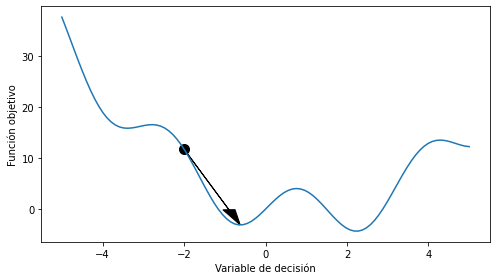

In [5]:
x_plot = np.linspace(-5, 5, num=100)
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(x_plot, f(x_plot))
ax.scatter(x0, f(x0), s=100, c='k')
ax.arrow(x0, f(x0), solution.x[0]-x0, f(solution.x[0])-f(x0), 
         head_width=0.3, head_length=3, color='k', length_includes_head=True)
ax.set_xlabel('Variable de decisión')
ax.set_ylabel('Función objetivo');

> La función es no convexa y el método quasi-Newton ha encontrado un mínimo local

:::{hint}

En problemas no-convexos es conveniente probar distintas soluciones iniciales 

:::

In [6]:
x0 = np.array([-4.5, -2, 4])
solution = []
for x0_ in x0:
    solution.append(scipy.optimize.minimize(f, x0_))
    
bests = np.array([solution.x[0] for solution in solution])

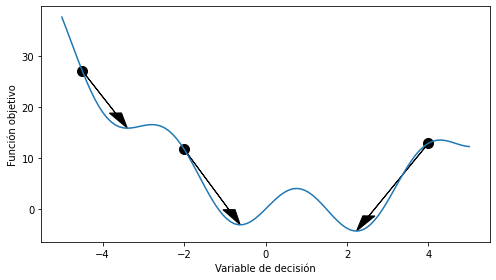

In [7]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(x_plot, f(x_plot))
ax.scatter(x0, f(x0), label='solución inicial', s=100, c='k')
for x0_, best in zip(x0, bests):
    ax.arrow(x0_, f(x0_), best-x0_, f(best)-f(x0_), 
             head_width=0.3, head_length=3, color='k', length_includes_head=True)
ax.set_xlabel('Variable de decisión')
ax.set_ylabel('Función objetivo');

El argumento `jac` de `minimize` espera la función de primeras derivadas o vector jacobiano. Este debe seguir una forma similar a la función objetivo

```python
def jac(x, *args):
    ...
    return dfoo 
```

donde

- donde `x` y `args` deben coincidir con `fun`. 
- `dfoo` debe tener la misma dimensionalidad de `x`

Si no se especifica `jac` las derivadas se calcularán de forma numérica, lo cual es menos eficiente

In [8]:
def df(x):
    return 2*x - 2 + 2*5*np.cos(2*x)

%timeit -r10 -n10 scipy.optimize.minimize(f, 0.0)
%timeit -r10 -n10 scipy.optimize.minimize(f, 0.0, jac=df)

2.4 ms ± 318 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
1.09 ms ± 29.4 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


A continuación describiremos algunos de los métodos disponibles a través del argumento `method` de `minimize`

### Métodos para optimización sin restricciones 

Con estos métodos no se pueden especificar los argumentos `constraint` y/o `bounds`. 

Por ejemplo están

- [`method=CG`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cg.html#optimize-minimize-cg): Gradiente conjugado. Es una versión de GD con tasa de aprendizaje adaptiva
- [`method=BFGS`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs): Es un método de tipo [quasi-Newton](https://en.wikipedia.org/wiki/Quasi-Newton_method) con Hessiano inverso aproximado a cada paso. 

Los cuales usan gradientes, ya sea numérico o especificado mediante el argumento `jac`. Si la derivada puede obtenerse analiticamente y es confiable estos métodos tendrán un desempeño superior a las alternativas
    
Luego están

- [`method=Nelder-Mead`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html#optimize-minimize-neldermead): Es una heurística tipo simplex. [Animación que muestra su funcionamiento](https://www.youtube.com/watch?v=HUqLxHfxWqU)
- [`method=Powell`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell): Algoritmo de búsqueda de linea siguiendo una dirección a la vez. [Animación que muestra su funcionamiento](https://www.youtube.com/watch?v=4TYJGihyuDg)

Los cuales no usan gradientes. Estos métodos pueden usarse cuando la función objetivo es no-derivable o demasiado ruidosa para ser derivada

### Métodos para optimización con restricciones

Con estos métodos se pueden incorporar restricciones al problema ya sea en forma de cotas para las variables o ecuaciones de igualdad/desigualdad que las variables deben cumplir

- Las restricciones de igualdad deben ser siempre de la forma $g(x) = 0$
- Las restricciones de desigualdad deben ser siempre de la forma $h(x) \geq 0 $

En la práctica las restricciones se entregan como una tupla en el argumento `constraint` de `method`. Cada restricción es un diccionario con las llaves `type` y `fun` para especificar el tipo (string `eq` o `ineq`) y la función, respectivamente. Opcionalmente se puede especificar `jac`, la matriz de primeras derivadas de `fun` y `arg` una tupla con argumentos adicionales para `fun` y `jac`

Por ejemplo si se tiene la siguiente restricción 

$$
x^2 \geq 1 + 2x
$$

se escribe como:

```python
h1 = {'type': 'ineq', 
      'fun' : lambda x: x**2 - 2*x -1,
      'jac' : lambda x: np.array([2*x - 2])}
```

:::{warning}

Si tenemos restricciones del tipo $h(x)\leq 0$ debemos transformarlas a $-h(x)\geq 0$ antes de implementarlas

:::

Los métodos que permiten especificar restricciones son

- [`L-BFGS-B`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html): Similar a BFGS pero permite añadir cotas (`bounds`) para la variable de decisión
- [`SLSQP`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html): *Sequential Least Squares Programming*. Este método acepta cotas, restricciones de igualdad y restricciones de desigualdad

**Ejemplo**

Sea la siguiente función de costo con dos variables de decisión

$$
\min f(x, y) = -(2xy+2x-x^2-2y^2) 
$$

sujeta a 

$$
x^3 - y = 0 ~\wedge~y-(x-1)^4-2 \geq 0 
$$

donde

$$
0.5\leq x \leq 1.5 ~\wedge~ 1.5 \leq y \leq 2.5
$$

Resolvamos utilizando `minimize`. La solución sin considerar restricciones sería:

In [9]:
def f(z):
    return -(2*z[0]*z[1] + 2*z[0] - z[0]**2 - 2*z[1]**2)

def df(z):
    return np.array([-2*z[1] - 2 + 2*z[0], -2*z[0] + 4*z[1]])

x0 = np.array([0, 1])

solution_no_constraint = scipy.optimize.minimize(f, x0, jac=df, method='BFGS')
solution_no_constraint.x

array([2., 1.])

La solución considerando cotas paras las variables de decisión sería:

In [10]:
bounds = ((0.5, 1.5), (1.5, 2.5))
solution_with_bounds = scipy.optimize.minimize(f, x0, jac=df, method='L-BFGS-B', bounds=bounds)
solution_with_bounds.x

array([1.5, 1.5])

Finalmente la solución considerando cotas y restricciones sería:

In [11]:
cons = ({'type': 'eq', 
         'fun': lambda z: z[0]**3 - z[1], 
         'jac': lambda z: np.array([3*z[0]**2, -1.])
        },
        {'type': 'ineq',
         'fun': lambda z: z[1] - (z[0]-1)**4 - 2,
         'jac': lambda z: np.array([-4*(z[0]-1)**3, 1.])
        })

solution_with_constraints = scipy.optimize.minimize(f, x0, jac=df, method='SLSQP', 
                                                    bounds=bounds, constraints=cons)
solution_with_constraints.x

array([1.26089314, 2.00463288])

Podemos visualizar estas soluciones con `matplotlib`, el color de la superficie representa la función objetivo, el área oscura las cotas y las lineas punteadas las restricciones

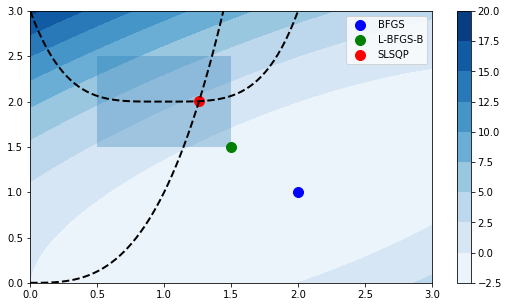

In [12]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
A, B = np.meshgrid(x, y)
C = f(np.vstack([A.ravel(), B.ravel()])).reshape((100,100))
fig, ax = plt.subplots(figsize=(9, 5))
cm = ax.contourf(A, B, C, cmap=plt.cm.Blues);
ax.plot(x, x**3, 'k--', lw=2)
ax.plot(x, 2+(x-1)**4, 'k--', lw=2)
ax.fill([0.5, 0.5, 1.5, 1.5], [2.5, 1.5, 1.5, 2.5], alpha=0.3)
ax.axis([0, 3, 0, 3])
ax.scatter(solution_no_constraint.x[0], solution_no_constraint.x[1], 
           s=100, c='b', label='BFGS');
ax.scatter(solution_with_bounds.x[0], solution_with_bounds.x[1], 
           s=100, c='g', label='L-BFGS-B');
ax.scatter(solution_with_constraints.x[0], solution_with_constraints.x[1], 
           s=100, c='r', label='SLSQP');
fig.colorbar(cm)
plt.legend();

## Más allá de esta lección

:::{seealso}

Funcionalidades de SciPy que no se exploraron en esta lección:

- [Encontrando raices de una función](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html#scipy.optimize.root)
- [Solución de problemas de programación lineal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html#scipy.optimize.linprog)

:::


:::{warning}

Tenga en cuenta las siguientes limitaciones:

- Scipy puede ser lento para problemas de gran envergadura. Si este es el caso sugiero explorar los wrappers de Python de [CVXOPT](https://www.cvxpy.org/)
- Scipy no tiene optimizadores para variables de decisión discretas. En caso de necesitar utilizar un algoritmo de optimización externo/comercial (por ejemplo CPLEX, Gurobi o AMPL) , sugiero explorar la librería [Pyomo](http://www.pyomo.org/documentation)

:::

